In [1]:
import os
from glob import glob
from numpy import genfromtxt
import numpy as np
import pandas as pd
import peakutils
from scipy.signal import find_peaks, savgol_filter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cwd = os.getcwd()
files = glob("*.csv")

In [3]:
for i in files:
    print(i)

0.008333 ml min-1_002.csv
0.08333 ml min-1_001.csv
0.1 ml min-1_001.csv
0.125 ml min-1_001.csv
0.1666 ml min-1_002.csv
0.25 ml min-1_002.csv
0.5 ml min-1_002.csv


In [4]:
def load_file(i):
    with open(files[i],"r") as datafile:
        for ix,line in enumerate(datafile):
            line=line.strip()
            if line=="Operator Name  :":
                break # ready for some data
    df = pd.read_csv(files[i], sep=',', skiprows=1, nrows=ix-6, usecols=['Time (min)', 'Abs'])
    return df

def find_peak(i,plot=True):
    df = load_file(i)
    smoothed_Abs = savgol_filter(df['Abs'], window_length=1000, polyorder=2)
    peaks,_ = find_peaks(smoothed_Abs,height=0.15,distance =20000)
    indexes = peakutils.indexes(smoothed_Abs, thres=0.15, min_dist=1000)
    ixmin = np.array([np.argmin(i) for i in np.split(smoothed_Abs, indexes)])
    ixmin[1:] += indexes
    
    if plot == True:
        fix,ax = plt.subplots()
        ax.plot(df['Time (min)'],df['Abs'],df['Time (min)'],smoothed_Abs,df['Time (min)'][peaks],smoothed_Abs[peaks],'x',df['Time (min)'][ixmin],smoothed_Abs[ixmin],'o')
    return peaks,smoothed_Abs,ixmin
    
def data_process(i):
    df = load_file(i)
    peaks,smoothed_Abs,ixmin = find_peak(i,plot=False)
    #delta_t = [df['Time (min)'][0]] + [df['Time (min)'][i+1]-df['Time (min)'][i] for i in range(len(df['Time (min)'])-1)]
        
    # split up the x and y values based on those minima
    xsplit = np.split(np.array(df['Time (min)']), ixmin[1:-1])[-1]
    ysplit = np.split(smoothed_Abs, ixmin[1:-1])[-1]
    theta = [t / df['Time (min)'][peaks].values[0] for t in xsplit]
    
    Q = np.trapz(ysplit, theta)         #sum([smoothed_Abs[i]*delta_t[i] for i in range(len(smoothed_Abs))])
    E = [C/Q for C in ysplit]
    
    return theta,E

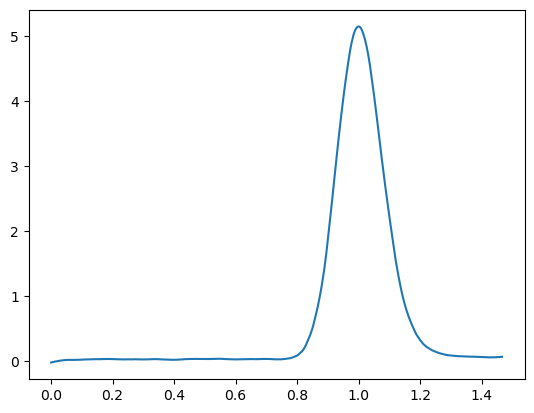

In [5]:
fix,ax = plt.subplots()
theta,E = data_process(5)
ax.plot(theta,E)

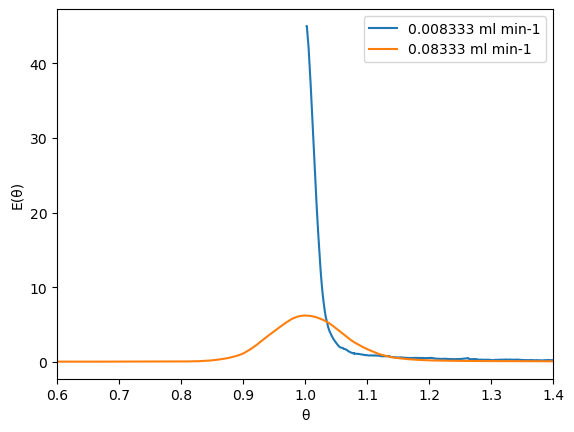

In [8]:
line_color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd","#8c564b", "#e377c2", "#7f7f7f"]
fix,ax = plt.subplots()
ax.set_xlim(0.6,1.4)
plt.ylabel("E(θ)")
plt.xlabel("θ")
#ax.set_ylim(0,6.5)
legend = []
for i in [0,1]:
    theta,E = data_process(i)
    ax.plot(theta,E,color = line_color[i])
    legend.append(files[i].split('_')[0])
plt.legend(legend)
plt.savefig('1.pdf', dpi=300, bbox_inches='tight')

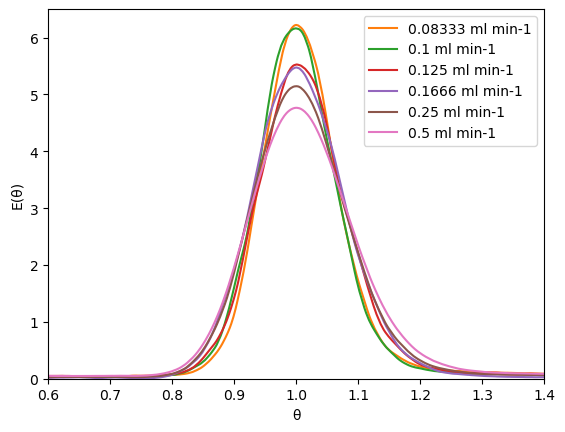

In [9]:
fix,ax = plt.subplots()
ax.set_xlim(0.6,1.4)
ax.set_ylim(0,6.5)
plt.ylabel("E(θ)")
plt.xlabel("θ")
legend = []
for i in [1,2,3,4,5,6]:
    theta,E = data_process(i)
    ax.plot(theta,E,color = line_color[i])
    legend.append(files[i].split('_')[0])
plt.legend(legend)
plt.savefig('2.pdf', dpi=300, bbox_inches='tight')